# Flight Delay Analysis

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

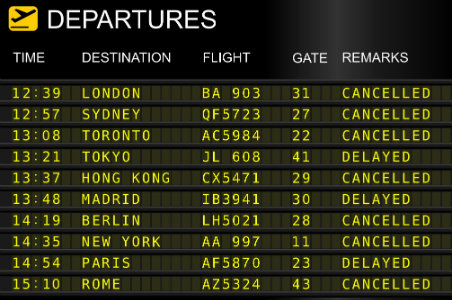

In [2]:
from IPython.display import Image                        
url='https://www.touristlegalassistance.com/wp-content/uploads/2017/05/flight-delays.jpg'
Image(url,width=1000, height=800)

In [3]:
import findspark
findspark.init()

In [4]:
findspark.find()
import pyspark
findspark.find()

'/opt/spark-2.4.4-bin-hadoop2.7'

In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAppName('appName').setMaster('local[4]')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

## Introduction to the Flights dataset

According to a 2010 report made by the US Federal Aviation Administration, the economic price of domestic flight delays entails a yearly cost of 32.9 billion dollars to passengers, airlines and other parts of the economy. More than half of that amount comes from passengers' pockets, as they do not only waste time waiting for their planes to leave, but also miss connecting flights, spend money on food and have to sleep on hotel rooms while they're stranded.

The report, focusing on data from year 2007, estimated that air transportation delays put a 4 billion dollar dent in the country's gross domestic product that year. Full report can be found 
<a href="http://www.isr.umd.edu/NEXTOR/pubs/TDI_Report_Final_10_18_10_V3.pdf">here</a>.

But which are the causes for these delays?

In order to answer this question, we are going to analyze the provided dataset, containing up to 1.936.758 different internal flights in the US for 2008 and their causes for delay, diversion and cancellation; if any.

The data comes from the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS)

This dataset is composed by the following variables:
1. **Year** 2008
2. **Month** 1
3. **DayofMonth** 1-31
4. **DayOfWeek** 1 (Monday) - 7 (Sunday)
5. **DepTime** actual departure time (local, hhmm)
6. **CRSDepTime** scheduled departure time (local, hhmm)
7. **ArrTime** actual arrival time (local, hhmm)
8. **CRSArrTime** scheduled arrival time (local, hhmm)
9. **UniqueCarrie**r unique carrier code
10. **FlightNum** flight number
11. **TailNum** plane tail number: aircraft registration, unique aircraft identifier
12. **ActualElapsedTime** in minutes
13. **CRSElapsedTime** in minutes
14. **AirTime** in minutes
15. **ArrDelay** arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
16. **DepDelay** departure delay, in minutes
17. **Origin** origin IATA airport code
18. **Dest** destination IATA airport code
19. **Distance** in miles
20. **TaxiIn** taxi in time, in minutes
21. **TaxiOut** taxi out time in minutes
22. **Cancelled** *was the flight cancelled
23. **CancellationCode** reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. **Diverted** 1 = yes, 0 = no
25. **CarrierDelay** in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
26. **WeatherDelay** in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
27. **NASDelay** in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
28. **SecurityDelay** in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
29. **LateAircraftDelay** in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation

Read the CSV file using Spark's default delimiter (","). The first line contains the headers so it is not part of the data. Hence we set the header option to true.

In [6]:
# This does nothing: Spark is lazy so the read operation will be deferred until an action is executed
flightsDF = spark.read.option("header", "true")\
                      .option("inferSchema", "true")\
                      .option("quote", "\"") \
                      .option("escape", "\"") \
                      .option("mode", "DROPMALFORMED")\
                      .csv("flights_jan08.csv")

## Your topic: Arrival Delay per State

We want to check what happens in each of the states, and if there is a relation between the state and the delay that goes beyond the airports. For that purpose, **you have to get (or build yourself) a small dataset relating each airport with the US state where it is located**. Ideally, the dataset should also have a column showing the location of the state in terms of west coast, east coast, middle-west, north-west, middle-east, etc. Divide the US states in a few groups for that. Once you have it, answer the following questions:

* What are the top 5 states with the highest mean arrival delay?
* What are the top 5 states with the highest *percentage of flights arriving on time* (delay < 15 minutes) ?
* Is there a relation between the geographical location of the states (the group) and the arrival delay? Support your conclusions with data, doing all analyses you consider necessary to prove your answer.
* Is there a relation between the flight distance and the origin *airport*? What about the destination airport? Can we say that the average distance of the flights arriving to some specific airports is clearly smaller or larger than others? Is this phenomenon related with the size of the city?
* Are there *states* where the ratio of delayed flights (arrival delay) changes a lot between the weekdays and the weekend, while other states keep a more constant ratio of delayed flights? Support your answer with data. Can you see reasons for this?


## Table of contents

[Map](#zeroth-bullet) <br>
[0.Merging Datasets](#first-bullet) <br>
[1.Top 5 states with the highest mean arrival delay](#second-bullet) <br>
[2.Top 5 states with the highest percentage of flights arriving on time](#third-bullet) <br>
[3.Relation between the geographical location of the states and the arrival delay](#fourth-bullet) <br>
[4.Relation between flight distances and cities (origin, destination)](#fifth-bullet) <br>
[5.States - arrival delay on weekdays vs. weekends](#sixth-bullet) <br>

## Map <a class="anchor" id="zeroth-bullet"></a>
Here is a map of the states that might be useful as some of the findings are related to states' location (East, West coast).


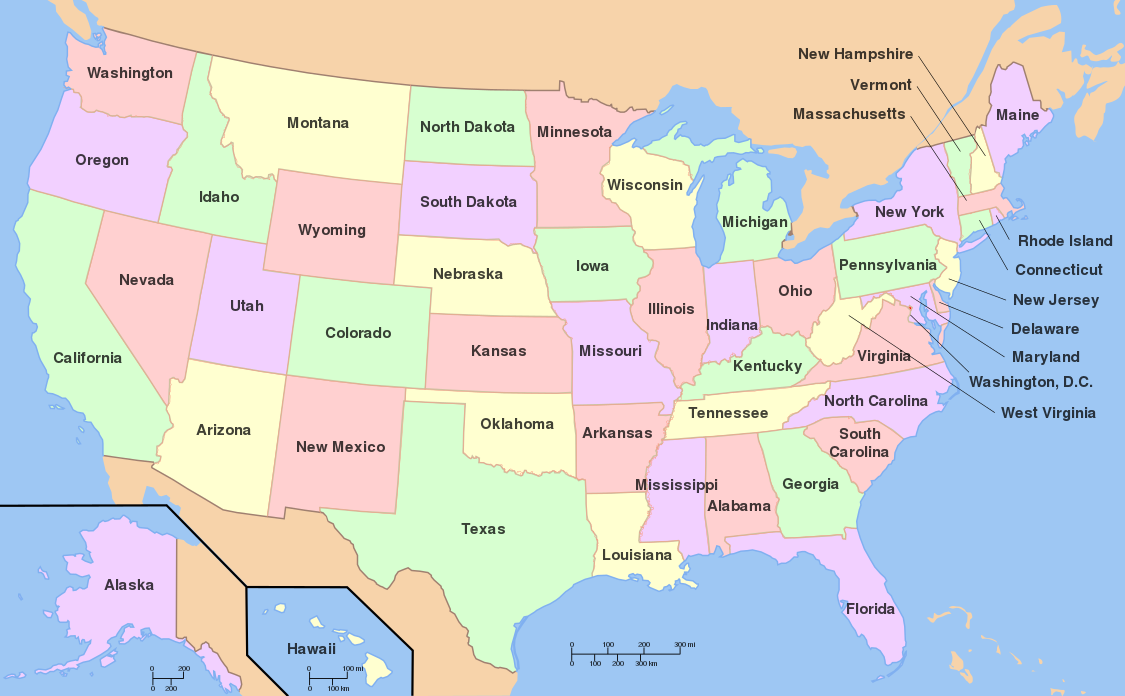

In [7]:
from IPython.display import Image
url='https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Map_of_USA_with_state_names.svg/1125px-Map_of_USA_with_state_names.svg.png'
Image(url,width=1000, height=800)

In [8]:
#To check initial the number of distinct origin & verify after the join that we have the same number
#flightsDF.select('Origin').distinct().count()

In [9]:
from pyspark.sql.functions import when, count, col, countDistinct, desc, first

## 0. Merging Datasets  <a class="anchor" id="first-bullet"></a>

The goal of this initial section is to build a complete dataframe (in three steps) using joins for state & state location for origin & destination. <br>

We want to create a complete dataframe that contains all the features we might need for the analysis, using two additional datasets. <br>
We need columns describing the state for each airport(statesDF), as well as its location (airportsDF). <br>
We want to have a complete description of both the origin *and* destination airports i.e. state, division and region for origin & destination for each flight.

In [10]:
# create the two dataframes for state (NY) + state location (NorthEast...)
airportsDF = spark.read.option('header', 'true').csv("us-airports.csv")

statesDF = spark.read\
                 .option("header", "true")\
                 .option("inferSchema", "true")\
                 .option("quote", "\"") \
                 .option("escape", "\"") \
                 .option("mode", "DROPMALFORMED")\
                 .csv("states.csv")

In [11]:
#drop unwanted columns from the airportsDF
drop_list = ['id','ident','type','latitude_deg','longitude_deg','elevation_ft','municipality','name','wikipedia_link',\
                   'continent', 'iso_country', 'scheduled_service','gps_code','home_link','keywords','score','last_updated']
airportsDF = airportsDF.select([column for column in airportsDF.columns if column not in drop_list]) 
#airports.select("iso_region").distinct().count() #nnumber of states (52)
#airports.select("iata_code").distinct().count()

#execute the 2 lines below to get an overview of the data contained in the columns to see on which to merge/join.
#flightsDF.select("Origin").show(1)
#airportsDF.select("iso_region", "iata_code","local_code").where(col("iata_code") == "LAX").show() #check the iso region for los angeles airport = CA -> OK

### A. Join the two dataframes we just created

In [12]:
# JOIN STATE + LOCATION (NEast, MidWest etc ++ DIVISION!)
joinedDF= airportsDF.join(statesDF, statesDF.State_Code == airportsDF.iso_region,"outer")
joinedDF.dtypes
joinedDF.select("iso_region","iata_code","local_code","State","State_code","Region","Division").show(5) #get a mini random sample to check if the resulting DF makes sense

+----------+---------+----------+-------+----------+------+--------+
|iso_region|iata_code|local_code|  State|State_code|Region|Division|
+----------+---------+----------+-------+----------+------+--------+
|        AZ|      PHX|       PHX|Arizona|        AZ|  West|Mountain|
|        AZ|      TUS|       TUS|Arizona|        AZ|  West|Mountain|
|        AZ|      SCF|       SDL|Arizona|        AZ|  West|Mountain|
|        AZ|      PRC|       PRC|Arizona|        AZ|  West|Mountain|
|        AZ|      SDX|       SEZ|Arizona|        AZ|  West|Mountain|
+----------+---------+----------+-------+----------+------+--------+
only showing top 5 rows



### B. Join with flightsDF for origin

In [13]:
flightsDF= flightsDF.join(joinedDF, joinedDF.local_code == flightsDF.Origin, "inner")
#flightsDF.select("Origin","Dest","iata_code","State_Code", "Region").where("Origin == 'PHX'").show(69)
#check that we still have 100k rows: flightsDF.select("Origin").count()
flightsDF.select("Origin","State_Code").where("Origin == 'PHX'").show(5)

+------+----------+
|Origin|State_Code|
+------+----------+
|   PHX|        AZ|
|   PHX|        AZ|
|   PHX|        AZ|
|   PHX|        AZ|
|   PHX|        AZ|
+------+----------+
only showing top 5 rows



In [14]:
# we rename the columns related to the origin airport (since we will later add the same columns for arrival airport)
import pyspark.sql.functions as F

flightsDF = flightsDF.withColumnRenamed("iata_code", "Origin_code")\
.withColumnRenamed("State_Code","Origin_state_code")\
.withColumnRenamed("Region", "Origin_region")\
.withColumnRenamed("iso_region","Origin_iso_region")\
.withColumnRenamed("local_code", "Origin_local_code")\
.withColumnRenamed("Division", "Origin_division")\
.withColumnRenamed("State","Origin_state")

### C. Join with flightsDF for destination

In [15]:
flightsDF= flightsDF.join(joinedDF, joinedDF.local_code == flightsDF.Dest, "inner")
flightsDF.select("Origin","Dest","iata_code","State_Code", "Region").where("Dest == 'ATL'").show(69)
#check that we still have 100k rows: flightsDF.select("Origin").count()

+------+----+---------+----------+------+
|Origin|Dest|iata_code|State_Code|Region|
+------+----+---------+----------+------+
|   CLE| ATL|      ATL|        GA| South|
+------+----+---------+----------+------+



In [16]:
import pyspark.sql.functions as F
flightsDF = flightsDF.withColumnRenamed("iata_code", "Dest_code")\
.withColumnRenamed("State_Code","Dest_state_code")\
.withColumnRenamed("Region", "Dest_region")\
.withColumnRenamed("iso_region","Dest_iso_region")\
.withColumnRenamed("local_code", "Dest_local_code")\
.withColumnRenamed("Division", "Dest_division")\
.withColumnRenamed("State","Dest_state")

In [17]:
flightsDF.select("Origin","Dest","Origin_State_Code", "Origin_Region","Origin_Division","Dest_state_code","Dest_region","Dest_division").where("Dest == 'ATL'").show(69)

+------+----+-----------------+-------------+------------------+---------------+-----------+--------------+
|Origin|Dest|Origin_State_Code|Origin_Region|   Origin_Division|Dest_state_code|Dest_region| Dest_division|
+------+----+-----------------+-------------+------------------+---------------+-----------+--------------+
|   CLE| ATL|               OH|      Midwest|East North Central|             GA|      South|South Atlantic|
+------+----+-----------------+-------------+------------------+---------------+-----------+--------------+



In [18]:
naCount = flightsDF.where("ArrDelay = 'NA'").count()
# The where function could also have been specified as .where(F.col("ArrDelay") == "NA"). Both are equivalent.

print("There are ", naCount, "rows with NA in ArrDelay")

There are  1302 rows with NA in ArrDelay


In [19]:
from pyspark.sql.types import IntegerType

flightsDF = flightsDF.where(("ArrDelay != 'NA'" and "DepDelay != 'NA'"))\
                     .withColumn("ArrDelay", F.col("ArrDelay").cast(IntegerType()))\
                     .withColumn("DepDelay", F.col("DepDelay").cast(IntegerType()))
# We will use this sub dataset later again.
flightsDF.cache()
#flightsDF.dtypes

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: int, AirTime: string, ArrDelay: int, DepDelay: int, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string, Origin_iso_region: string, Origin_code: string, Origin_local_code: string, Origin_state: string, Origin_state_code: string, Origin_region: string, Origin_division: string, Dest_iso_region: string, Dest_code: string, Dest_local_code: string, Dest_state: string, Dest_state_code: string, Dest_region: string, Dest_division: string]

In [20]:
flightsDF.count() # we have a slightly smaller dataset (less rows) because we have removed the rows that contain no information with regards to arrival and departure delay

98858

## 1. Top 5 states with the highest mean arrival delay  <a class="anchor" id="second-bullet"></a>

As we can see from the table in A and B, some states have a high mean for both leaving and incoming flights: <br>
- Nevada
- California
- Utah
- Idaho
<br>

The remaining two are Illinois (planes leaving from there have high average arrival delay) and South Carolina (planes arriving there have high average arrival delay). <br> <br>
Here is the actual break-down:<br>
Top 5 states (origin): 1.Utah, 2.Nevada, 3.Idaho, 4.California 5.Illinois <br>
Top 5 states (destination): 1.South Carolina, 2.Utah, 3. California, 4.Idaho, 5.Nevada


### A. Top 5 states(ORIGIN)
We investigate which origins have the highest average delay upon arrival. We focus on the airport of "origin".

In [21]:
high_mean_ARRdelay_origin = flightsDF.groupBy("Origin_State").agg(F.mean("ArrDelay").alias("States_Mean_ArrDelay"))\
                                .withColumn("States_Mean_ArrDelay", F.round("States_Mean_ArrDelay",3))\
                                  .sort(desc("States_Mean_ArrDelay"))

high_mean_ARRdelay_origin.show(5)

+------------+--------------------+
|Origin_State|States_Mean_ArrDelay|
+------------+--------------------+
|        Utah|              13.683|
|      Nevada|              11.848|
|       Idaho|              10.214|
|  California|              10.162|
|    Illinois|               9.571|
+------------+--------------------+
only showing top 5 rows



### B. Top 5 states (DESTINATION)

We investigate which destinations have the highest average delay at arrival. We focus on the airport of "destination".

In [22]:
high_mean_ARRdelay_destination = flightsDF.groupBy("Dest_State").agg(F.mean("ArrDelay").alias("Dest_Mean_ArrDelay"))\
                            .withColumn("Dest_Mean_ArrDelay",F.round("Dest_Mean_ArrDelay",3))\
                              .sort(desc("Dest_Mean_ArrDelay"))

high_mean_ARRdelay_destination.show(5)

+--------------+------------------+
|    Dest_State|Dest_Mean_ArrDelay|
+--------------+------------------+
|South Carolina|              18.0|
|          Utah|            11.544|
|    California|            10.089|
|         Idaho|            10.006|
|        Nevada|             9.669|
+--------------+------------------+
only showing top 5 rows



## 2. Top 5 states with the highest percentage of flights arriving on time (delay < 15 minutes) <a class="anchor" id="third-bullet"></a>

The first step is to create a separate dataframe (to keep the original intact) with a column to distinguish "ontime" and "late" flights: *flightsDF1*.
<br> The column we added is binary and informs whether the flight was ontime or not. In our case, "on time" means the flight has a delay inferior to 15 minutes.

In part A: The top 5 "on time" states (destination state) are:
- Alabama
- Florida
- Maryland
- Virginia
- Louisiana

The results shows mostly airports with a lower smaller of flights, since we are looking purely at the on time rate.

In part B: top 5 states "on time" (origin state):
- West Viriginia
- Wisconsin
- South Carolina
- Virginia
- Connecticut

The results are even more biased towards states with a lower number of outgoing flights:

If we looked at the number of flights on time, the results would have been quite different.
States (origin and destination states) with highest NUMBER of flights arriving on time:
- California
- Texas
- Florida
- Nevada
- Arizona (for origin) / Illinois (for destination)
<br>  <br>

The results of the question related to findings the "Top 5 states with the highest percentage of flights arriving on time" show there is a bias towards states that have fewer flights. This makes sense because less busy airports are more likely to fly according to shcedule as there is less traffic.


In [23]:
flightsDF1 = flightsDF.withColumn("ArrOntime", F.when(F.col("ArrDelay") < 15, 1)\
                                              .otherwise(0))

In [24]:
flightsDF1.select("Origin", "Dest","ArrDelay","ArrOntime").show(2) 
flightsDF1.cache()

+------+----+--------+---------+
|Origin|Dest|ArrDelay|ArrOntime|
+------+----+--------+---------+
|   LAS| MSY|       5|        1|
|   LAS| MSY|      94|        0|
+------+----+--------+---------+
only showing top 2 rows



DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: int, AirTime: string, ArrDelay: int, DepDelay: int, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string, Origin_iso_region: string, Origin_code: string, Origin_local_code: string, Origin_state: string, Origin_state_code: string, Origin_region: string, Origin_division: string, Dest_iso_region: string, Dest_code: string, Dest_local_code: string, Dest_state: string, Dest_state_code: string, Dest_region: string, Dest_division: string, ArrOntime: int]

### A. Top 5 states - on time (destination: number and ratio)
Now that we have the column to see whether a flight is on time or not, we can find which states have the highest percentage of fligths arriving on time. 
We are looking at the question this way: out of all the flights that land in a state, how many arrived on time.

In [25]:
#in order to look at the question from a "highest number of flights on time perspective":
##remove the ".sort(desc("OnTimeRate")).

OnTime_dest = flightsDF1.groupBy("Dest_State_Code","Dest_state")\
                   .agg(F.count("ArrDelay").alias("TotalFlights"),\
                        F.sum("ArrOntime").alias("FlightsOnTime"))\
                   .sort(desc("FlightsOnTime"))

OnTime_dest = OnTime_dest.withColumn("OnTimeRate", F.col("FlightsOnTime")/F.col("TotalFlights"))\
                            .withColumn("OnTimeRate",F.round("OnTimeRate",3)).sort(desc("OnTimeRate"))
OnTime_dest.show(5)

+---------------+----------+------------+-------------+----------+
|Dest_State_Code|Dest_state|TotalFlights|FlightsOnTime|OnTimeRate|
+---------------+----------+------------+-------------+----------+
|             AL|   Alabama|         809|          701|     0.867|
|             FL|   Florida|        8274|         7161|     0.865|
|             MD|  Maryland|        4660|         4015|     0.862|
|             VA|  Virginia|         359|          306|     0.852|
|             LA| Louisiana|        1256|         1064|     0.847|
+---------------+----------+------------+-------------+----------+
only showing top 5 rows



### B. Top 5 states - on time (origin: number and ratio)
We will look at the same question, but from the perspective of origin. Out of all the flights that leave from a state, how many arrive on time at destination.

In [26]:
#in order to look at the question from a "highest number of flights on time perspective":
##remove the ".sort(desc("OnTimeRate")).

OnTime_origin = flightsDF1.groupBy("Origin_State_Code","Origin_state")\
                   .agg(F.count("ArrDelay").alias("TotalFlights"),\
                        F.sum("ArrOntime").alias("FlightsOnTime"))\
                   .sort(desc("FlightsOnTime"))

OnTime_origin = OnTime_origin.withColumn("OnTimeRate", F.col("FlightsOnTime")/F.col("TotalFlights"))\
                            .withColumn("OnTimeRate",F.round("OnTimeRate",3)).sort(desc("OnTimeRate"))
OnTime_origin.show(5)

+-----------------+--------------+------------+-------------+----------+
|Origin_State_Code|  Origin_state|TotalFlights|FlightsOnTime|OnTimeRate|
+-----------------+--------------+------------+-------------+----------+
|               WV| West Virginia|           1|            1|       1.0|
|               WI|     Wisconsin|           1|            1|       1.0|
|               SC|South Carolina|           1|            1|       1.0|
|               CT|   Connecticut|         509|          452|     0.888|
|               VA|      Virginia|         362|          321|     0.887|
+-----------------+--------------+------------+-------------+----------+
only showing top 5 rows



## 3. Relation between the geographical location of the states (the group) and the arrival delay <a class="anchor" id="fourth-bullet"></a>

Geography: location of a state and its relation with arrival delay. <br>
Does the location of the origin airport have an impact on the delay? are there patterns? <br> <br>
We will first split delay into categories. <br>
Then we will look at delay by state, region and division, and see if we can find a pattern. <br>

Parts A, B and C show that there are a couple factors to take into account:
- Delay in Division / Region / State seem to match (because utlimately the same airports are affected).
- Delay category should be taken into account to get more precise results
- Areas with less lower densities are less prone to delays i.e. delays occur more frequently in states that have a high population contration and thus more flights


In [27]:
FlightsDF2 = flightsDF.withColumn("ArrDelay", F.col("ArrDelay").cast(IntegerType()))\
                          .withColumn("DepDelay", F.col("DepDelay").cast(IntegerType()))\
                          .withColumn("ArrDelayCat", F.when(F.col("ArrDelay")<15, "None")\
                                                      .when((F.col("ArrDelay") >=15) & (F.col("ArrDelay")<60), "Slight")\
                                                      .otherwise("Huge"))\
# We will use this sub dataset later again.
FlightsDF2.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: int, AirTime: string, ArrDelay: int, DepDelay: int, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string, Origin_iso_region: string, Origin_code: string, Origin_local_code: string, Origin_state: string, Origin_state_code: string, Origin_region: string, Origin_division: string, Dest_iso_region: string, Dest_code: string, Dest_local_code: string, Dest_state: string, Dest_state_code: string, Dest_region: string, Dest_division: string, ArrDelayCat: string]

In [28]:
#FlightsDF2.select("Origin").show(5)

### A.Delay by division

We can see from the first table below that flights most prone to arrival delay originate from Pacific and Mountain region.
This makes sense as these are the divisions with most flights. There is a relation between the arrival delay and the amount of flights that leave from one airport.
Indeed, if there are more flights, it's more likely to have delay since the planes might need to queue at the runway to get authorisation to fly. Same applies to landing.

Another possible explanations is meteorological: Pacific and Mountain areas are most likely to suffer from meteorological variations.

Next we look at the same issue, this time removing "ontime" flights. Middle Atlantic and New England, that had an overall negative Arrival delay, are now in the top 5.

Finally, we look at top 5 states for the flights with huge delay only.

We can see that looking at the same problem with a different perspective yields different results. 

#### > Number of flights and average arrival delay by ORIGIN_DIVISION

In [29]:
averageDelayPerOriginDivision = FlightsDF2.groupBy("Origin_division")\
                                         .agg(F.count("Origin_code").alias("TotalFlights"), F.sum("ArrDelay").alias("Sum_delay"),F.mean("ArrDelay"). alias("avgArrDelay"), \
                                             F.mean("DepDelay").alias("avgDepDelay"))\
                                         .sort(F.col("avgArrDelay").desc())\
                                        .withColumn("avgArrDelay", F.round("avgArrDelay",3))\
                                        .withColumn("avgDepDelay",F.round("avgDepDelay",3))
averageDelayPerOriginDivision.show()

+------------------+------------+---------+-----------+-----------+
|   Origin_division|TotalFlights|Sum_delay|avgArrDelay|avgDepDelay|
+------------------+------------+---------+-----------+-----------+
|           Pacific|       24333|   231766|      9.541|      13.41|
|          Mountain|       20237|   165554|      8.195|     12.777|
|East North Central|        8516|    64861|      7.633|     12.653|
|West North Central|        4790|    26074|      5.454|      8.496|
|West South Central|       16126|    68714|      4.268|      7.572|
|East South Central|        3887|     9620|      2.477|      6.401|
|    South Atlantic|       14699|     4924|      0.335|      6.607|
|       New England|        2304|     -807|     -0.351|      7.304|
|   Middle Atlantic|        3966|    -5171|     -1.306|      8.019|
+------------------+------------+---------+-----------+-----------+



#### > Ommitting "ontime" Flights (i.e. less than 15 min late)

In [30]:
removing_on_time_flights = FlightsDF2.where("ArrDelayCat !='None'").groupBy("Origin_division")\
                                         .agg(F.count("Origin_code").alias("TotalFlights"), F.sum("ArrDelay").alias("Sum_delay"),F.mean("ArrDelay"). alias("avgArrDelay"), \
                                             F.mean("DepDelay").alias("avgDepDelay"))\
                                         .sort(F.col("avgArrDelay").desc())\
                                        .withColumn("avgArrDelay", F.round("avgArrDelay",3))\
                                        .withColumn("avgDepDelay",F.round("avgDepDelay",3))
removing_on_time_flights.show()

+------------------+------------+---------+-----------+-----------+
|   Origin_division|TotalFlights|Sum_delay|avgArrDelay|avgDepDelay|
+------------------+------------+---------+-----------+-----------+
|East North Central|        1869|   105109|     56.785|     51.355|
|           Pacific|        5835|   299167|     51.634|     50.856|
|          Mountain|        4800|   241515|     50.685|     48.593|
|   Middle Atlantic|         581|    28199|     49.213|     46.119|
|       New England|         344|    16308|     47.824|     42.703|
|West North Central|         975|    45211|     46.802|     41.133|
|West South Central|        2708|   118946|     44.383|     42.538|
|    South Atlantic|        2036|    88643|     43.861|     41.787|
|East South Central|         641|    26913|     42.183|     37.793|
+------------------+------------+---------+-----------+-----------+



#### > Looking at "huge" delayed flights (i.e. 60 min +)

In [31]:
severe_delay = FlightsDF2.where("ArrDelayCat ='Huge'").groupBy("Origin_division")\
                                         .agg(F.count("Origin_code").alias("TotalFlights"), F.sum("ArrDelay").alias("Sum_delay"),F.mean("ArrDelay"). alias("avgArrDelay"), \
                                             F.mean("DepDelay").alias("avgDepDelay"))\
                                         .sort(F.col("avgArrDelay").desc())\
                                        .withColumn("avgArrDelay", F.round("avgArrDelay",3))\
                                        .withColumn("avgDepDelay",F.round("avgDepDelay",3))
severe_delay.show()

+------------------+------------+---------+-----------+-----------+
|   Origin_division|TotalFlights|Sum_delay|avgArrDelay|avgDepDelay|
+------------------+------------+---------+-----------+-----------+
|East North Central|         532|    65053|    126.562|    113.235|
|West North Central|         200|    22761|    119.168|    107.205|
|   Middle Atlantic|         137|    14744|    114.295|    102.701|
|          Mountain|        1249|   136056|    112.072|    107.447|
|           Pacific|        1589|   169760|    109.664|    106.601|
|West South Central|         564|    57785|    107.808|    100.381|
|       New England|          86|     8845|    106.566|      93.57|
|East South Central|         120|    12102|    103.436|     97.208|
|    South Atlantic|         433|    41657|     99.658|     93.898|
+------------------+------------+---------+-----------+-----------+



### B. Delay by region

We have two tables below: the average delay by origin region, and a table with the number of flights that originate from each region.
As we have seen previously, there is a relation between the number of flights and the average delay, again related to traffic. We will not do a break down by delay category as the question was more specifically for the "group" of states.

#### > Average arrival delay by origin region

In [32]:
averageDelayPerOriginRegion = FlightsDF2.groupBy("Origin_region")\
                                         .agg(F.count("Origin_code").alias("TotalFlights"), F.sum("ArrDelay").alias("Sum_delay"),F.mean("ArrDelay"). alias("avgArrDelay"), \
                                             F.mean("DepDelay").alias("avgDepDelay"))\
                                         .sort(F.col("avgArrDelay").desc())\
                                        .withColumn("avgArrDelay", F.round("avgArrDelay",3))\
                                        .withColumn("avgDepDelay",F.round("avgDepDelay",3))
averageDelayPerOriginRegion.show()

+-------------+------------+---------+-----------+-----------+
|Origin_region|TotalFlights|Sum_delay|avgArrDelay|avgDepDelay|
+-------------+------------+---------+-----------+-----------+
|         West|       44570|   397320|       8.93|     13.122|
|      Midwest|       13306|    90935|      6.848|     11.156|
|        South|       34712|    83258|      2.402|      7.032|
|    Northeast|        6270|    -5978|     -0.955|      7.756|
+-------------+------------+---------+-----------+-----------+



#### > States within most affected regions

In [33]:
a = FlightsDF2.select("Origin_state", "Origin_division","Origin_region").where("Origin_region == 'West'or Origin_region= 'Midwest'").sort("Origin_region")
a.distinct().show()

+------------+------------------+-------------+
|Origin_state|   Origin_division|Origin_region|
+------------+------------------+-------------+
|    Illinois|East North Central|      Midwest|
|    Missouri|West North Central|      Midwest|
|        Ohio|East North Central|      Midwest|
|     Indiana|East North Central|      Midwest|
|    Nebraska|West North Central|      Midwest|
|    Michigan|East North Central|      Midwest|
|   Wisconsin|East North Central|      Midwest|
|      Nevada|          Mountain|         West|
|     Arizona|          Mountain|         West|
|  Washington|           Pacific|         West|
|  California|           Pacific|         West|
|        Utah|          Mountain|         West|
|      Oregon|           Pacific|         West|
|       Idaho|          Mountain|         West|
|    Colorado|          Mountain|         West|
|  New Mexico|          Mountain|         West|
+------------+------------------+-------------+



### The cell below is just to show 
1. Relation btw delay for region and division, as well as number of flights
2. States in the divisions Mountain and Pacific relate to state region "WEST" (results of the counts below = 0)

In [34]:
FlightsDF2.groupBy("Origin_division","Origin_region").agg(F.count("Origin_code").alias("number_flights")).sort(F.col("number_flights").desc()).show()

#there are no origin_region different to West in the divisions Mountain and Pacific
FlightsDF2.select("Origin_division","Origin_region").where("Origin_division == 'Mountain' and Origin_region!='West'").count()
FlightsDF2.select("Origin_division","Origin_region").where("Origin_division == 'Pacific' and Origin_region!='West'").count()

+------------------+-------------+--------------+
|   Origin_division|Origin_region|number_flights|
+------------------+-------------+--------------+
|           Pacific|         West|         24333|
|          Mountain|         West|         20237|
|West South Central|        South|         16126|
|    South Atlantic|        South|         14699|
|East North Central|      Midwest|          8516|
|West North Central|      Midwest|          4790|
|   Middle Atlantic|    Northeast|          3966|
|East South Central|        South|          3887|
|       New England|    Northeast|          2304|
+------------------+-------------+--------------+



0

### C.Delay by state

Here we see that the top 3 states (with highest mean arrival delay for flights) are located in "Mountain" division and West region, which is consistent with the previous findings. Just like we did for division, we are only looking at delay in general, not specific for huge delay or removing ontime flights (again in connection with the scope of the question).

In [35]:
averageDelayPerOriginState = FlightsDF2.groupBy("Origin_state", "Origin_division","Origin_region")\
                                         .agg(F.mean("ArrDelay"). alias("avgArrDelay"), \
                                             F.mean("DepDelay").alias("avgDepDelay"))\
                                         .sort(F.col("avgArrDelay").desc())\
                                        .withColumn("avgArrDelay", F.round("avgArrDelay",3))\
                                        .withColumn("avgDepDelay",F.round("avgDepDelay",3))
                                        
averageDelayPerOriginState.show(3)

+------------+---------------+-------------+-----------+-----------+
|Origin_state|Origin_division|Origin_region|avgArrDelay|avgDepDelay|
+------------+---------------+-------------+-----------+-----------+
|        Utah|       Mountain|         West|     13.683|      16.25|
|      Nevada|       Mountain|         West|     11.848|     15.395|
|       Idaho|       Mountain|         West|     10.214|     12.032|
+------------+---------------+-------------+-----------+-----------+
only showing top 3 rows



## 4. Relation between flight distances and cities (origin, destination) <a class="anchor" id="fifth-bullet"></a>
Is there a relation between the flight distance and the origin airport? What about the destination airport? Can we say that the average distance of the flights arriving to some specific airports is clearly smaller or larger than others? Is this phenomenon related with the size of the city?

Intial assumptions:
- Airports greater average distance are big and important airports that fly all over the country (West to East for example).
- A shorter average distance would point to small regional airports that fly only to the closest hubs.
- Hubs might not appear on the top distance as they fly to both nearby local airports and across the country.

#### Based on parts A and B below:

We can say that the assumptions hold. Indeed, the airports that have the greatest distance on average are city airports (usually international airports). The distance would probably be even greater if we included international flights.

City airports serve a greater number of passengers, and thus offer a bigger diversity of destinations.

There seems to be no hubs in the top 5.


Is there a relation between the flight distance and the origin airport?
What about the destination airport? 
Can we say that the average distance of the flights arriving to some specific airports is clearly smaller or larger than others? 
Is this phenomenon related with the size of the city?

### A. Distance vs. Origin Airport
Get the distance for every route: i.e. by grouping by origin and destination and looking at the "average" which is equivalent to the distance between origin and destination airports.

#### Some findings regarding the relation between the flight distance and the origin airport:

 - the top 5 for average distance are all located on the East Coast. This can be explained by coast-to-coast flights and because they serve a bridges to fly to Europe.
 - west coast airports are not in the top 5
  - airports with higher average relate to hubs and big airports (city airports such as Chicago)
 - airports with smaller average relate to tiny regional airports that usually serve only a couple of destinations (the hubs). These airports are linked to hubs, from where passengers can travel fiurther.



The first table shows the average distance of each flight route (10 first rows). We grouped We grouped the dataframe by origin and dest (both).

In [36]:
FlightsDF2.groupBy("Origin","Dest").agg(F.round(F.mean("Distance"),0).alias("Avg_dist")).sort(F.col("Avg_dist").desc()).show(10)
#get the average distance for each flight route (grouped by origin + dest

+------+----+--------+
|Origin|Dest|Avg_dist|
+------+----+--------+
|   LAS| PVD|  2363.0|
|   PVD| LAS|  2363.0|
|   MHT| LAS|  2356.0|
|   LAS| MHT|  2356.0|
|   LAS| BDL|  2298.0|
|   BDL| LAS|  2298.0|
|   SAN| BWI|  2295.0|
|   BWI| SAN|  2295.0|
|   ISP| LAS|  2283.0|
|   LAS| ISP|  2283.0|
+------+----+--------+
only showing top 10 rows



This next table looks at total distance and total flights. We can see already here that the main airports are located the coasts. It is outside the scope of the question, its goal is to provide a first overview

1. Chicago (East)
2. Las Vegas (West)
3. Phoenix (West)
4. Baltimore-Chicago (East)
5. Orlando (East)

In [37]:
FlightsDF2.groupBy("Origin").agg(F.round(F.sum("Distance"),0).alias("total_Distance"),F.count("Origin_code").alias("TotalFlights")).sort(F.col("total_Distance").desc()).show(5)


+------+--------------+------------+
|Origin|total_Distance|TotalFlights|
+------+--------------+------------+
|   MDW|       5283111|        6225|
|   LAS|       4873124|        6737|
|   PHX|       4017170|        5500|
|   BWI|       3026913|        4556|
|   MCO|       2792850|        3292|
+------+--------------+------------+
only showing top 5 rows



#### >Top 5 airports by avg_distance are:
1. Charleston airport (East Coast)
2. Dayton international airport (East)
3. Charlotte Douglas international airport (East)
4. Chicago airport (North East)
5. Orlando airport (East)

These output makes sense: The top 5 are international airports (although here we focus on domestic flights) so they most likely serve as hubs domestically. <br>
An interesting finding is that the top 5 airports in terms of average distance are all located in the East coast. <br>
We could have expected to find East and West Coast airports, but this turns out not to be the case. <br>
The top 5 are not in the "middle", which means they can fly from one coast to the other, which explains why they have a higher average distance.

We are only looking at domestic flights so we are disregarding information on international flights. Some airports probably have longer routes when operating non-domestic.





In [38]:
#top 5 airports for longest average distance
FlightsDF2.groupBy("Origin").agg(F.round(F.mean("Distance"),0).alias("avg_Distance")).sort(F.col("avg_Distance").desc()).show(5)

+------+------------+
|Origin|avg_Distance|
+------+------------+
|   CRW|       975.0|
|   DAY|       929.0|
|   CLT|       913.0|
|   MDW|       849.0|
|   MCO|       848.0|
+------+------------+
only showing top 5 rows



The top 5 airport for shortest average distance are regional airports, i.e. airportst that bring passengers to a hub, from where they can fly longer routes.
1. Lake Charles Regional Airport (flights to Dallas and Houston: hubs)
2. Corpus Christi airport (name says it all) (flights to Dallas and Houston: hubs)
3. Lafayette Regional Airport (its top destinations are Dallas, Houston and Atlanta: all hubs)
4. Meadow Fields County Airport (its top destinations are San Francisco, Dallas, Denver and Phoenix: all hubs)
5. Rochester Airport (top destination: Orlando, Chicago, New York, Atlanta)

In [39]:
#top 5 airports for shortest average distance
FlightsDF2.groupBy("Origin").agg(F.round(F.mean("Distance"),0).alias("avg_Distance")).sort(F.col("avg_Distance").asc()).show(5)


+------+------------+
|Origin|avg_Distance|
+------+------------+
|   LCH|       127.0|
|   CRP|       187.0|
|   LFT|       201.0|
|   BFL|       240.0|
|   ROC|       246.0|
+------+------------+
only showing top 5 rows



### B. Distance vs. Destination Airport

#### This confirms what we saw with regards to origin.
- destinations for which distance is bigger are usually city airports that fly across the country
- destinations that have smaller average distance are small regional airpors that only fly to hubs.



In [40]:
FlightsDF2.groupBy("Dest").agg(F.round(F.mean("Distance"),0).alias("avg_Distance")).sort(F.col("avg_Distance").desc()).show(5)

+----+------------+
|Dest|avg_Distance|
+----+------------+
| RIC|      1157.0|
| MDW|       853.0|
| SAV|       851.0|
| MCO|       849.0|
| ISP|       843.0|
+----+------------+
only showing top 5 rows



In [41]:
FlightsDF2.groupBy("Dest").agg(F.round(F.mean("Distance"),0).alias("avg_Distance")).sort(F.col("avg_Distance").asc()).show(5)

+----+------------+
|Dest|avg_Distance|
+----+------------+
| CRP|       187.0|
| SYR|       194.0|
| BFL|       240.0|
| ROC|       245.0|
| FAT|       261.0|
+----+------------+
only showing top 5 rows



## 5. States arrival delay - weekdays vs. weekends  <a class="anchor" id="sixth-bullet"></a>

### States where the ratio of delayed flights (arrival delay) changes a lot between the weekdays and the weekend, while other states keep a more constant ratio of delayed flights? Support your answer with data. Can you see reasons for this?

To solve this question, we compute

a. ArrDelay rate on weekdays

b. ArrDelay rate on weekend

We will see the difference in terms of ArrDelay rate between weekdays and weekend, and what reasons are behind.

One assumption is that some airports are busy in the week because they are places where people travel for business purposes, so the ratio of delays should be higher in the week since the airport is busier. <br>
Another assumption is that some airports are simply busier than others: these should have a small difference in the ratio. <br>
Another factor to take into account for generally high ratios is weather. A quick reminder that we are looking at the data for January.

The final table of part A shows the ratio of delayed flight during the week days, by state.
Top states include New Jersey, Utah and Illinois. The reasons can be three-fold:
1. Busy airspace (NJ is close to New-York).
2. Weather conditions: snow storms can cause massive delays
3. Security linked to weather: de-icing planes takes time

The final table for part B shows the ratio of delayed flights during the weekends, by state.
Top states include Nevada, California and Utah. Reasons can be two-fold:
- Airports operate over capacity at weekends because they serve popular destination
- Weather

In part C we merge the final tables of A & B to compute the difference between week and weekend ratio across states. <br>
This will allow to identify states that have a stable ratio (small difference) and those that do not.


### A. Delayed flights during weekdays

We first create a subset of flightsDF with the columns of interest and removing "on time" flights.


In [42]:
# If 'ArrDelay' >= 15, we call it 'Delayed' as mentioned above.
# We need the reasons for delay, so we change the column types from string to integer, and replace 'NA' to 0.

flightsDF_Delayed = flightsDF.select("Origin_State_Code","ArrDelay",
                                     "CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay")\
                             .withColumn("Arr_Delayed", F.when(F.col("ArrDelay") >= 15, 1).otherwise(0))\
                             .replace("NA", "0")

We then cast specific columns into integers. This will allow us to "count" later on.


In [43]:
flightsDF_Delayed = flightsDF_Delayed.withColumn("CarrierDelay", col("CarrierDelay").cast(IntegerType()))\
                                     .withColumn("WeatherDelay", col("WeatherDelay").cast(IntegerType()))\
                                     .withColumn("NASDelay", col("NASDelay").cast(IntegerType()))\
                                     .withColumn("SecurityDelay", col("SecurityDelay").cast(IntegerType()))\
                                     .withColumn("LateAircraftDelay", col("LateAircraftDelay").cast(IntegerType()))\

# We will use this sub dataset later again.
flightsDF_Delayed.cache()

DataFrame[Origin_State_Code: string, ArrDelay: int, CarrierDelay: int, WeatherDelay: int, NASDelay: int, SecurityDelay: int, LateAircraftDelay: int, Arr_Delayed: int]

In [44]:
#flightsDF_Delayed.where("SecurityDelay != 0").show(5) remove # to run an example.

In [45]:
# We take a subset that contains only weekdays: 1 ~ 5

flightsDF_Delayed_Weekdays = flightsDF_Delayed.where("DayOfWeek < 6")

#flightsDF_Delayed_Weekdays.show()

In [46]:
# Compute aggregated values.

Delayed_Weekdays = flightsDF_Delayed_Weekdays.groupBy("Origin_State_Code")\
                                         .agg(F.count("ArrDelay").alias("TotalFlights"),\
                                              F.sum("Arr_Delayed").alias("SumFlightsDelayed"),\
                                              F.sum("CarrierDelay").alias("Carrier_WD"),\
                                              F.sum("WeatherDelay").alias("Weather_WD"),\
                                              F.sum("NASDelay").alias("NAS_WD"),\
                                              F.sum("SecurityDelay").alias("Security_WD"),\
                                              F.sum("LateAircraftDelay").alias("LateAircraft_WD"))\
                                         .sort(desc("SumFlightsDelayed"))

Delayed_Weekdays.show()

+-----------------+------------+-----------------+----------+----------+------+-----------+---------------+
|Origin_State_Code|TotalFlights|SumFlightsDelayed|Carrier_WD|Weather_WD|NAS_WD|Security_WD|LateAircraft_WD|
+-----------------+------------+-----------------+----------+----------+------+-----------+---------------+
|               CA|       16028|             3636|     29876|      4905| 27016|        236|         108908|
|               TX|        9863|             1674|     16109|      1708|  8985|         23|          46541|
|               NV|        5957|             1516|     12852|      2568| 12120|        173|          38405|
|               IL|        4663|             1225|     18769|      4989| 12989|        323|          38747|
|               AZ|        4805|              959|     10304|       372|  4977|         66|          24434|
|               FL|        6183|              737|      7036|      1409|  5075|        117|          18788|
|               MO|        3

In [47]:
# Show ArrDelay rate and reasons for the delay during the WeekDays.
Weekdays_Delay_Rate = Delayed_Weekdays.select(F.col("Origin_State_Code"),\
                                             (F.col("SumFlightsDelayed") / F.col("TotalFlights") * 100).alias("Weekdays_Delay_Rate"),\
                                              F.col("Carrier_WD"),\
                                              F.col("Weather_WD"),\
                                              F.col("NAS_WD"),\
                                              F.col("Security_WD"),\
                                              F.col("LateAircraft_WD")).withColumn("Weekdays_Delay_Rate", F.round("Weekdays_Delay_Rate",2))

Weekdays_Delay_Rate.sort(desc("Weekdays_Delay_Rate")).show()

+-----------------+-------------------+----------+----------+------+-----------+---------------+
|Origin_State_Code|Weekdays_Delay_Rate|Carrier_WD|Weather_WD|NAS_WD|Security_WD|LateAircraft_WD|
+-----------------+-------------------+----------+----------+------+-----------+---------------+
|               NJ|              33.33|        37|         0|    17|          0|            105|
|               UT|              27.73|      1721|      1301|  3777|          0|          10424|
|               IL|              26.27|     18769|      4989| 12989|        323|          38747|
|               NV|              25.45|     12852|      2568| 12120|        173|          38405|
|               CA|              22.69|     29876|      4905| 27016|        236|         108908|
|               ID|              21.67|       480|        19|   769|        239|           3900|
|               MO|              21.21|      4656|      1832|  7060|          0|          17766|
|               AZ|           

### B. Delayed flights during weekend

In [48]:
# We take a subset that contains only weekend: 6, 7

flightsDF_Delayed_Weekend = flightsDF_Delayed.where("DayOfWeek > 5")

#flightsDF_Delayed_Weekend.show()

In [49]:
# Compute aggregated values.

Delayed_Weekend = flightsDF_Delayed_Weekend.groupBy("Origin_State_Code")\
                                           .agg(F.count("ArrDelay").alias("TotalFlights"),\
                                                F.sum("Arr_Delayed").alias("SumFlightsDelayed"),\
                                                F.sum("CarrierDelay").alias("Carrier_WE"),\
                                                F.sum("WeatherDelay").alias("Weather_WE"),\
                                                F.sum("NASDelay").alias("NAS_WE"),\
                                                F.sum("SecurityDelay").alias("Security_WE"),\
                                                F.sum("LateAircraftDelay").alias("LateAircraft_WE"))\
                                           .sort(desc("SumFlightsDelayed"))

Delayed_Weekend.show()

+-----------------+------------+-----------------+----------+----------+------+-----------+---------------+
|Origin_State_Code|TotalFlights|SumFlightsDelayed|Carrier_WE|Weather_WE|NAS_WE|Security_WE|LateAircraft_WE|
+-----------------+------------+-----------------+----------+----------+------+-----------+---------------+
|               CA|        5127|             1529|     17281|      3229| 12843|        291|          63434|
|               NV|        2007|              665|      7502|      1465|  5207|         80|          34599|
|               TX|        3035|              507|      4799|      1741|  2328|          6|          13955|
|               FL|        2167|              407|      4166|       514|  3802|         80|           7209|
|               AZ|        1573|              374|      3702|      1029|  2944|         36|          12852|
|               IL|        1553|              308|      3551|      1114|  2756|        115|           5949|
|               MO|         

In [50]:
## Show ArrDelay rate and reasons for the delay during the WeekDays.

Weekend_Delay_Rate = Delayed_Weekend.select(F.col("Origin_State_Code"),\
                                           (F.col("SumFlightsDelayed") / F.col("TotalFlights") * 100).alias("Weekend_Delay_Rate"),\
                                            F.col("Carrier_WE"),\
                                            F.col("Weather_WE"),\
                                            F.col("NAS_WE"),\
                                            F.col("Security_WE"),\
                                            F.col("LateAircraft_WE")).withColumn("Weekend_Delay_Rate", F.round("Weekend_Delay_Rate",2))

Weekend_Delay_Rate.sort(desc("Weekend_Delay_Rate")).show()

+-----------------+------------------+----------+----------+------+-----------+---------------+
|Origin_State_Code|Weekend_Delay_Rate|Carrier_WE|Weather_WE|NAS_WE|Security_WE|LateAircraft_WE|
+-----------------+------------------+----------+----------+------+-----------+---------------+
|               NV|             33.13|      7502|      1465|  5207|         80|          34599|
|               UT|             31.08|      1371|       781|  2055|          0|           4118|
|               CA|             29.82|     17281|      3229| 12843|        291|          63434|
|               ID|             29.14|       253|         0|   383|          0|           2078|
|               OR|             25.09|       819|       388|   622|          0|           2460|
|               NE|              25.0|       708|         0|   536|          0|            956|
|               WA|             24.74|      1568|       307|  1781|          4|           4063|
|               AZ|             23.78|  

### C. Merge two datasets

In [51]:
# Merge Weekdays and Weekend datasets to compute the difference of each rate.

new_DF = Weekdays_Delay_Rate.join(Weekend_Delay_Rate, on = "Origin_State_Code", how = "inner")

new_DF.show(2)

+-----------------+-------------------+----------+----------+------+-----------+---------------+------------------+----------+----------+------+-----------+---------------+
|Origin_State_Code|Weekdays_Delay_Rate|Carrier_WD|Weather_WD|NAS_WD|Security_WD|LateAircraft_WD|Weekend_Delay_Rate|Carrier_WE|Weather_WE|NAS_WE|Security_WE|LateAircraft_WE|
+-----------------+-------------------+----------+----------+------+-----------+---------------+------------------+----------+----------+------+-----------+---------------+
|               CA|              22.69|     29876|      4905| 27016|        236|         108908|             29.82|     17281|      3229| 12843|        291|          63434|
|               TX|              16.97|     16109|      1708|  8985|         23|          46541|             16.71|      4799|      1741|  2328|          6|          13955|
+-----------------+-------------------+----------+----------+------+-----------+---------------+------------------+----------+---------

In [52]:
# Compute difference of each rate and reasons for the delay.

Difference_DF = new_DF.select(F.col("Origin_State_Code"),\
                             (F.col("Weekdays_Delay_Rate") - F.col("Weekend_Delay_Rate")).alias("Rate_Diff"),\
                             (F.col("Carrier_WD") - F.col("Carrier_WE")).alias("Carrier_Diff"),\
                             (F.col("Weather_WD") - F.col("Weather_WE")).alias("Weather_Diff"),\
                             (F.col("NAS_WD") - F.col("NAS_WE")).alias("NAS_Diff"),\
                             (F.col("Security_WD") - F.col("Security_WE")).alias("Security_Diff"),\
                             (F.col("LateAircraft_WD") - F.col("LateAircraft_WE")).alias("LateAircraft_Diff"))\
                            .withColumn("Rate_Diff", F.round("Rate_Diff",2))

Difference_DF.sort(desc("Rate_Diff")).show()

+-----------------+---------+------------+------------+--------+-------------+-----------------+
|Origin_State_Code|Rate_Diff|Carrier_Diff|Weather_Diff|NAS_Diff|Security_Diff|LateAircraft_Diff|
+-----------------+---------+------------+------------+--------+-------------+-----------------+
|               NJ|    33.33|          37|           0|      17|            0|              105|
|               AR|     9.48|         484|           8|     113|            0|             1290|
|               MS|     7.77|         582|          65|     140|            0|              695|
|               IL|     6.44|       15218|        3875|   10233|          208|            32798|
|               MO|     4.53|        2893|        1306|    5857|            0|            13188|
|               RI|     4.09|         463|         338|    1816|            3|             2004|
|               PA|     3.64|        2303|         359|    2741|           11|             7644|
|               MD|     3.08| 

State "NJ" has the biggest difference in terms of ArrDelay rate between Weekdays and Weekend. This is because we have a small number of flights from New Jersey in the dataset (14 rows), so it is not very representative of the flow (100K flights).

In general, states show relatively constant delay rate.

Also, as we can see from the result above, the major reason for the delay is "Late Aircraft".

In [53]:
#to check the information related to flights from New Jersey
#flightsDF_Delayed.where("Origin_State_Code =='NJ'").show()

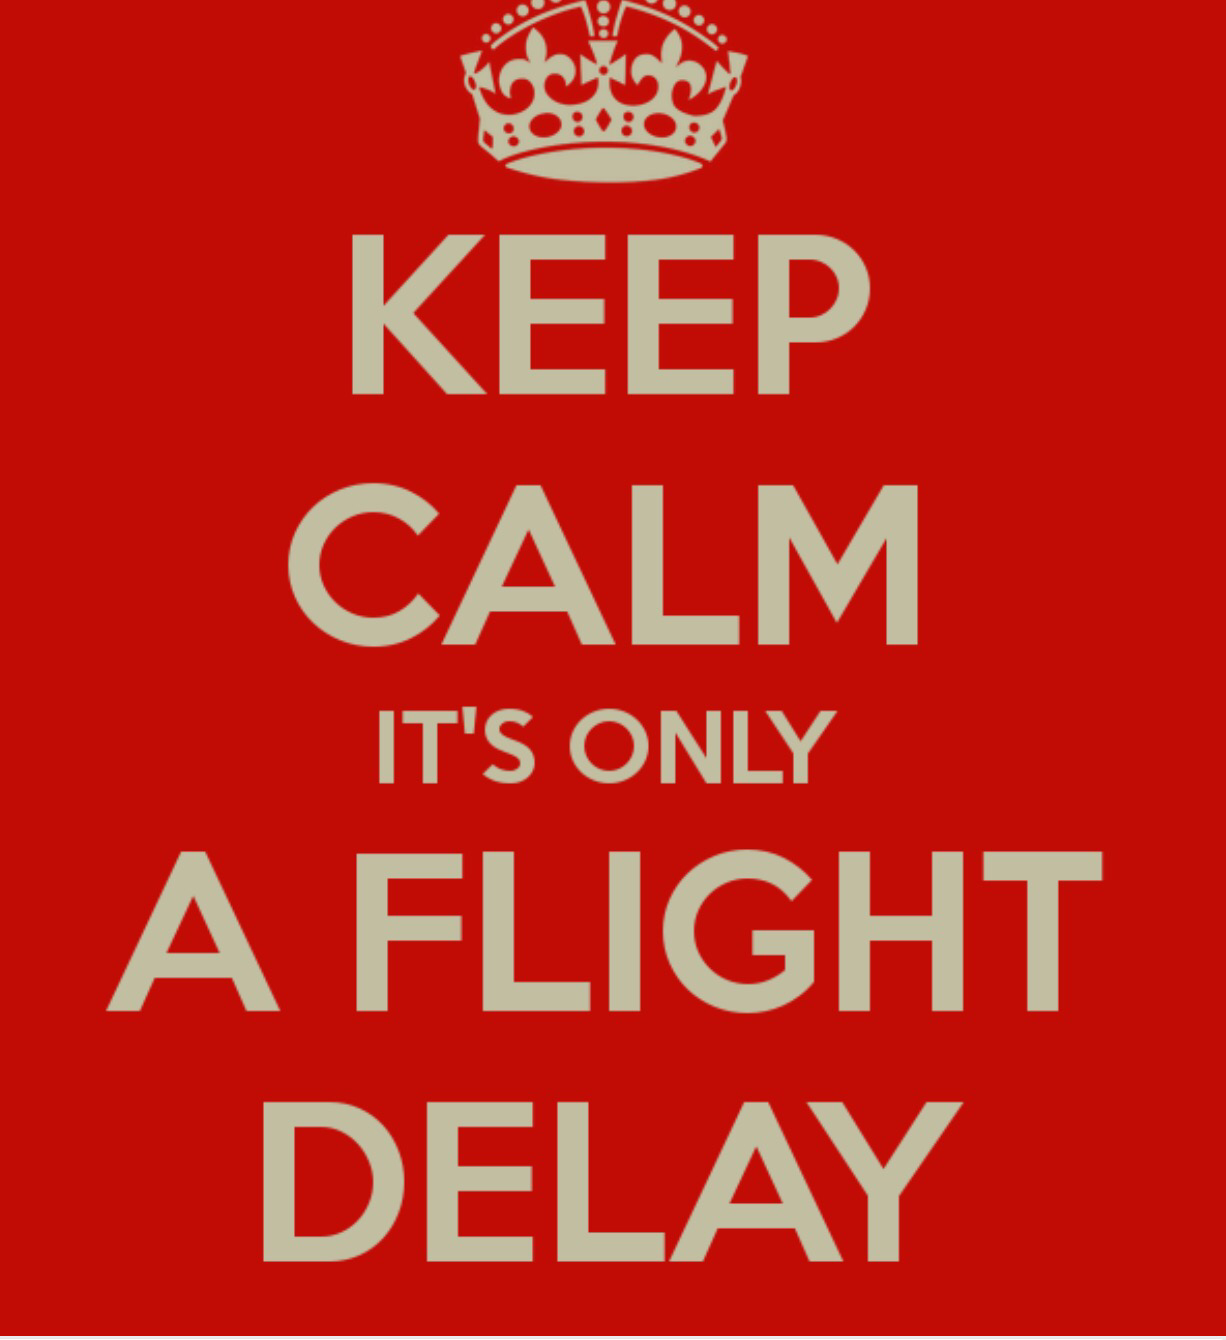

In [54]:
from IPython.display import Image                        
url='https://danyadarling.files.wordpress.com/2016/09/img_3149.png'
Image(url,width=900, height=800)